In [55]:
import numpy as np
base = '/home2/ebrahim/beyond-brainscore/'
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import sys
sys.path.append(base)
from plotting_functions import plot_across_subjects
from trained_results_funcs import find_best_layer, find_best_sigma
from untrained_results_funcs import compute_p_val

In [65]:
exp = ['243', '384']

br_labels_dict = {}
num_vox_dict = {}
subjects_dict = {}

data_processed_folder_pereira = f'/data/LLMs/data_processed/pereira/dataset'
data_processed_folder_fed = f'/data/LLMs/data_processed/fedorenko/dataset'
data_processed_folder_blank = f'/data/LLMs/data_processed/blank/dataset'

for e in exp:

    bre = np.load(f'{data_processed_folder_pereira}/networks_{e}.npy', allow_pickle=True)
    br_labels_dict[e] = bre
    num_vox_dict[e] = bre.shape[0]
    subjects_dict[e] = np.load(f"{data_processed_folder_pereira}/subjects_{e}.npy", allow_pickle=True)
    
lang_indices_384 = np.argwhere(br_labels_dict['384'] == 'language').squeeze()
lang_indices_243 = np.argwhere(br_labels_dict['243'] == 'language').squeeze()

subjects_arr_fed  = np.load(f"{data_processed_folder_fed}/subjects.npy", allow_pickle=True)
subjects_arr_blank  = np.load(f"{data_processed_folder_blank}/subjects.npy", allow_pickle=True)

subjects_arr_pereira = np.load(f"{data_processed_folder_pereira}/subjects_complete.npy", allow_pickle=True)
networks_arr_pereira = np.load(f"{data_processed_folder_pereira}/network_complete.npy", allow_pickle=True)
non_nan_indices_243 = np.load(f"{data_processed_folder_pereira}/non_nan_indices_243.npy") # voxels which are in 243
non_nan_indices_384 = np.load(f"{data_processed_folder_pereira}/non_nan_indices_384.npy") # voxels which are in 384

In [67]:
resultsPath = '/data/LLMs/brainscore/'
ytest_243 = np.load(f'{resultsPath}results_pereira/y_test_ordered_243.npy')
ytest_384 = np.load(f'{resultsPath}results_pereira/y_test_ordered_384.npy')
mse_intercept_243 = np.load(f'{resultsPath}results_pereira/mse_intercept_243.npy')
mse_intercept_384 = np.load(f'{resultsPath}results_pereira/mse_intercept_384.npy')
ytest_fed = np.load(f"{resultsPath}results_fedorenko/y_test_ordered.npy")
ytest_blank = np.load(f"{resultsPath}results_blank/y_test_ordered.npy")

In [78]:
shape_pereira_full = (627, int(subjects_arr_pereira.shape[0]))
ytest_pereira = np.full(shape_pereira_full, fill_value=np.nan)
ytest_pereira[:243, non_nan_indices_243] = ytest_243
ytest_pereira[243:, non_nan_indices_384] = ytest_384
mse_intercept_pereira_full = np.full(shape_pereira_full, fill_value=np.nan)
mse_intercept_pereira_full[:243, non_nan_indices_243] = mse_intercept_243
mse_intercept_pereira_full[243:, non_nan_indices_384] = mse_intercept_384

In [126]:
noL2_str = ''
resultsPath_pereira = f"{resultsPath}results_pereira/shuffled/"
perf = 'out_of_sample_r2'
fe = ''
dataset = 'pereira'

feature_extraction_methods = ['', '-mp', '-sp']
mse_best_layer = {}


for fe in feature_extraction_methods:
    
    y_hat_full = np.full(shape_pereira_full, fill_value=np.nan)

    gpt2_xl_384_dict, gpt2_xl_384_bl, gpt2_xl_384_bl_perf = find_best_layer(np.arange(0,49), noL2_str=noL2_str, exp='_384', 
                                                resultsPath=resultsPath_pereira, lang_indices=lang_indices_384, dataset=dataset, 
                                                subjects=subjects_dict['384'], perf=perf, feature_extraction=fe)
    gpt2_xl_243_dict, gpt2_xl_243_bl, gpt2_xl_243_bl_perf = find_best_layer(np.arange(0,49), noL2_str=noL2_str, exp='_243', 
                                                resultsPath=resultsPath_pereira, lang_indices=lang_indices_243, dataset=dataset, 
                                                subjects=subjects_dict['243'], perf=perf, feature_extraction=fe)
    
    
    best_layer_384 = max(gpt2_xl_384_dict, key=gpt2_xl_384_dict.get)
    best_layer_243 = max(gpt2_xl_243_dict, key=gpt2_xl_243_dict.get)
    
    y_hat_384 = np.load(f"{resultsPath_pereira}pereira_gpt2-xl{fe}_layer_{best_layer_384}_1_384.npz")['y_hat']
    y_hat_243 = np.load(f"{resultsPath_pereira}pereira_gpt2-xl{fe}_layer_{best_layer_243}_1_243.npz")['y_hat']
    
    y_hat_full[:243, non_nan_indices_243] = y_hat_243
    y_hat_full[243:, non_nan_indices_384] = y_hat_384
    
    mse_best_layer[fe] = (ytest_pereira - y_hat_full)**2

In [127]:
store_subject_network_idxs_384 = {}
store_subject_network_idxs_243 = {}
mse_subject_network_best_layer = {}
mse_subject_network_intercept = {}

from scipy.stats import ttest_rel

pvalues_pereira = {'fe': [], 'network': [], 'subject': [], 'pval': []}

for fe in feature_extraction_methods:

    mse_best_layer_fe = mse_best_layer[fe]
        
    for network in np.unique(bre):
        
        for subject in np.unique(subjects_dict[e]):
            
            print(fe, network, subject)
            
            subject_idxs = np.argwhere(subjects_arr_pereira==subject)
            network_idxs = np.argwhere(networks_arr_pereira==network)
            subject_network_idxs =  list(np.intersect1d(subject_idxs, network_idxs))
            
            stat, pval = ttest_rel(mse_best_layer_fe[:, subject_network_idxs], mse_intercept_pereira_full[:, subject_network_idxs], axis=0, nan_policy='omit')
            
            pvalues_pereira['pval'].extend(pval)
            pvalues_pereira['subject'].extend(np.repeat(subject,len(pval)))
            pvalues_pereira['network'].extend(np.repeat(network,len(pval)))
            
            if len(fe) == 0:
                fe_name = '-lt'
            else:
                fe_name = fe
                
            pvalues_pereira['fe'].extend(np.repeat(fe_name,len(pval)))
            
            

    
            
        

 DMN 018
 DMN 199


/tmp/ipykernel_962810/1082534305.py:24: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  stat, pval = ttest_rel(mse_best_layer_fe[:, subject_network_idxs], mse_intercept_pereira_full[:, subject_network_idxs], axis=0, nan_policy='omit')


 DMN 288
 DMN 289
 DMN 296
 DMN 343
 DMN 366
 DMN 407
 DMN 426
 MD 018
 MD 199
 MD 288
 MD 289
 MD 296
 MD 343
 MD 366
 MD 407
 MD 426
 auditory 018
 auditory 199
 auditory 288
 auditory 289
 auditory 296
 auditory 343
 auditory 366
 auditory 407
 auditory 426
 language 018
 language 199
 language 288
 language 289
 language 296
 language 343
 language 366
 language 407
 language 426
 visual 018
 visual 199
 visual 288
 visual 289
 visual 296
 visual 343
 visual 366
 visual 407
 visual 426
-mp DMN 018
-mp DMN 199
-mp DMN 288
-mp DMN 289
-mp DMN 296
-mp DMN 343
-mp DMN 366
-mp DMN 407
-mp DMN 426
-mp MD 018
-mp MD 199
-mp MD 288
-mp MD 289
-mp MD 296
-mp MD 343
-mp MD 366
-mp MD 407
-mp MD 426
-mp auditory 018
-mp auditory 199
-mp auditory 288
-mp auditory 289
-mp auditory 296
-mp auditory 343
-mp auditory 366
-mp auditory 407
-mp auditory 426
-mp language 018
-mp language 199
-mp language 288
-mp language 289
-mp language 296
-mp language 343
-mp language 366
-mp language 407
-mp langu

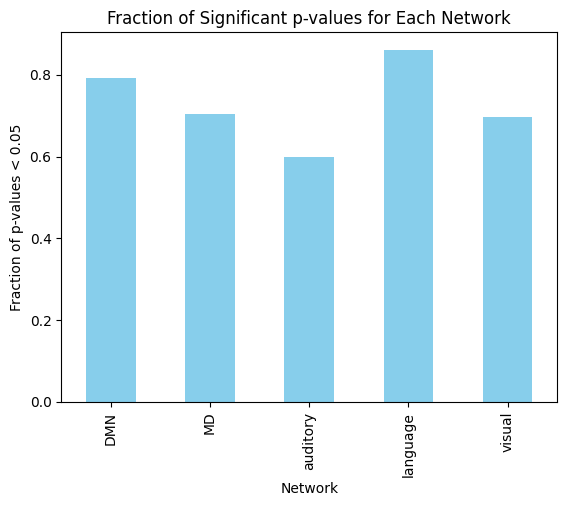

In [128]:
pvalues_pereira = pd.DataFrame(pvalues_pereira)

# Group by 'network' and calculate fraction of p-values under 0.05
fraction_under_005 = pvalues_pereira.groupby('network')['pval'].apply(lambda x: (x < 0.05).mean())

# Plot
fraction_under_005.plot(kind='bar', color='skyblue')
plt.ylabel("Fraction of p-values < 0.05")
plt.xlabel("Network")
plt.title("Fraction of Significant p-values for Each Network")
plt.show()


In [120]:
fraction_under_005_subj

NameError: name 'fraction_under_005_subj' is not defined

In [91]:

for key in mse_subject_network_best_layer.keys():
    
    
stat, p = ttest_rel(mse_subject_network_best_layer['018_DMN_'], mse_subject_network_intercept['018_DMN'], axis=0, nan_policy='omit')

In [97]:
# Example arrays with NaN values
a = np.array([1.2, 2.3, np.nan, 4.5, 5.6])
b = np.array([1.0, np.nan, 3.4, 4.6, 5.5])

# Perform paired t-test while ignoring NaN pairs
t_stat, p_val = ttest_rel(a, b, nan_policy="omit")

print("t-statistic:", t_stat)
print("p-value:", p_val)

# Example arrays with NaN values
a = np.array([1.2, 4.5, 5.6])
b = np.array([1.0, 4.6, 5.5])

# Perform paired t-test while ignoring NaN pairs
t_stat, p_val = ttest_rel(a, b, nan_policy="omit")

print("t-statistic:", t_stat)
print("p-value:", p_val)

t-statistic: 0.7559289460184556
p-value: 0.5285954792089678
t-statistic: 0.7559289460184556
p-value: 0.5285954792089678
